In [111]:
#first run the regression
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

totalDailyValue = pd.read_csv("Input/totalDailyValueDf.csv")
imbalance = pd.read_csv("Input/imbalanceDf.csv")
vwap330 = pd.read_csv("Input/vwap330Df.csv")
arrivalPrice = pd.read_csv("Input/arrivalPriceDf.csv")
terminalPrice = pd.read_csv("Input/terminalPriceDf.csv")
dailyVol = pd.read_csv("Input/dailyVolDf.csv")

# Drop the "Stock" column if present
totalDailyValue.drop("Stock", axis=1, inplace=True)
imbalance.drop("Stock", axis=1, inplace=True)
vwap330.drop("Stock", axis=1, inplace=True)
arrivalPrice.drop("Stock", axis=1, inplace=True)
terminalPrice.drop("Stock", axis=1, inplace=True)
dailyVol.drop("Stock", axis=1, inplace=True)

#compute rolling 10 day average of daily value
lookback = 10
avgDailyValue = totalDailyValue.copy()

queue = []
for c in totalDailyValue.columns:
    #add new day
    queue.append(totalDailyValue[c])


    if len(queue) == lookback:
        avgDailyValue[c] = sum(queue) / lookback

        #remove the earliest day in the queue
        queue.pop(0)
    else:
        avgDailyValue[c] = np.zeros_like(avgDailyValue.index)

#we use the data from day 11 and onwards because the daily vol and average value are not avaliable before then
totalDailyValue = totalDailyValue[totalDailyValue.columns[lookback:]]
imbalance = imbalance[imbalance.columns[lookback:]]
vwap330 = vwap330[vwap330.columns[lookback:]]
arrivalPrice = arrivalPrice[arrivalPrice.columns[lookback:]]
terminalPrice = terminalPrice[terminalPrice.columns[lookback:]]
dailyVol = dailyVol[dailyVol.columns[lookback:]]
avgDailyValue = avgDailyValue[avgDailyValue.columns[lookback:]]

# Extract the required data for computation
impact330 = vwap330 - arrivalPrice
permanent_impact = (terminalPrice - arrivalPrice)/2


Y = (impact330 - permanent_impact)  # temp_impact
X = imbalance
V = avgDailyValue

# Replace infinite and NaN values with stock specific means
Y = Y.apply(lambda row: row.fillna(row.mean()), axis=1)

#perform the non-linear regression to minimize the sum of squared error

#stack the data to one column
y = np.array(Y.stack())
x = np.array((X / (6*V/6.5)).stack())
sigma = np.array(dailyVol.stack())

def temp_impact(x,eta,beta):
    temporary_impact = eta * sigma * np.sign(x) * np.power(np.abs(x) , beta)
    return temporary_impact

# Perform the curve fitting
popt, pcov = curve_fit(temp_impact, x, y)

# popt contains the optimal values for eta and beta
eta_optimal = popt[0]
beta_optimal = popt[1]

y_pred = temp_impact(x,eta_optimal,beta_optimal)

residuals = y - y_pred

#print the result
print('Optimal eta: %.5f, Optimal beta: %.5f, MSE: %s'%(eta_optimal,beta_optimal,np.mean(np.square(residuals))))

Optimal eta: 0.33244, Optimal beta: 0.36127, MSE: 0.27720763715479035


**Assumptions of non-linear regressions:**

**Significance of Parameters:**

In [112]:
#in scipy's curve fit function, pcov is the covariance of the parameters, under the assumption of normality, we can test for its significance
from scipy.stats import norm
std_eta = np.sqrt(pcov[0][0])
std_beta = np.sqrt(pcov[1][1])

eta_pvalue = norm.sf(eta_optimal / std_eta)
beta_pvalue = norm.sf(beta_optimal / std_beta)

#note that this is a one tailed test, because we expect the trading rate to have a positive correlation with the temporary impact on price
print('eta p-value: %.5f, beta p-value: %.5f'%(eta_pvalue,beta_pvalue))
#both satisfy 99% confidence that the coeff is not 0

eta p-value: 0.00067, beta p-value: 0.00050


**Normality of Residuals:**

In [113]:
#we check for some of the standard assumptions of non-linear regression

#1: normality of residuals
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, kurtosistest, skewtest

skew_resi = skew(residuals)
kurt_resi = kurtosis(residuals)

test_skew = skewtest(residuals)
test_kurt = kurtosistest(residuals)


print("Skewness:", skew_resi)
print("Kurtosis:", kurt_resi)
print("Skewness Test:", test_skew)  
print("Kurtosis Test:", test_kurt)  

#these tests indicate that the residual is both skewed (to the right) and also heavily tailed, typical characteristics of financial data
#the result basically indicate that there are a few cases where the temporary impact is much bigger than predicted 

Skewness: 5.418978186088718
Kurtosis: 209.21090244445003
Skewness Test: SkewtestResult(statistic=139.25198684326767, pvalue=0.0)
Kurtosis Test: KurtosistestResult(statistic=107.37514180577018, pvalue=0.0)


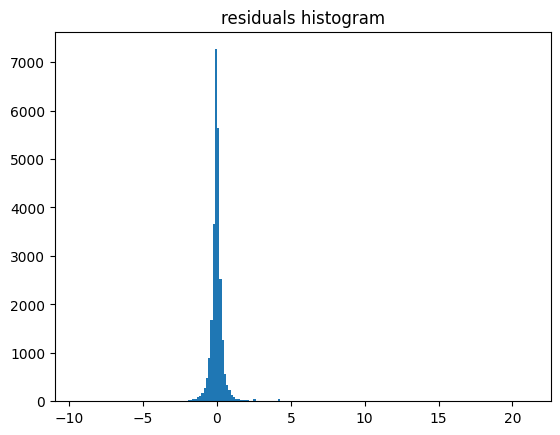

In [114]:
plt.hist(residuals,bins = 200)
plt.title('residuals histogram')
#plt.xlim((-3,3))
plt.show()

#the plot looks pretty nomrally shaped, with obviously big outliers

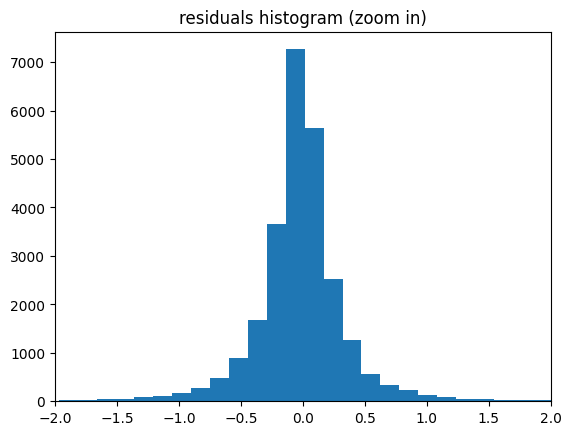

In [115]:
plt.hist(residuals,bins = 200)
plt.title('residuals histogram (zoom in)')
plt.xlim((-2,2))
plt.show()

#if we zoom in, we can see that it looks pretty normal around the center

**Independence of residuals (absence of serial correlation):**

In [116]:
#2: independence of error （serial correlation）
from scipy.stats import pearsonr

#we put the error back to its original tabular structure (each row is a stock and each column is one day)
residuals_structured = x.reshape(X.shape)

#define a function to calculate and test auto correlation of lag n
def serial_corr(data,lag = 1):
    correlation, p_value = pearsonr(data[:-lag], data[lag:])
    
    return correlation,p_value

num_corr = 0
confi_level = 0.99
for residuals_stock in residuals_structured:
    corr,p = serial_corr(residuals_stock)
    if p <= (1 - confi_level):
        num_corr += 1

print("number of stocks whose residuals have non-zero serial correlation (%s confidence): %s out of 509 stocks"%(confi_level,num_corr))
#generally, for most stocks, there are no serial correlation of errors

number of stocks whose residuals have non-zero serial correlation (0.99 confidence): 22 out of 509 stocks


**performance across liquid-illiquid stocks:**

In [117]:
#how does the model perform differently between liquid and illiquid stocks
from scipy.stats import mannwhitneyu
#we divide the stocks in to 3 category from least liquid to most liquid based on total daily value traded

boundary = int(len(residuals_structured) / 3)

least_liquid_indices = totalDailyValue.mean(axis=1).sort_values().index[:boundary]
medium_liquid_indices = totalDailyValue.mean(axis=1).sort_values().index[boundary:boundary*2]
most_liquid_indices = totalDailyValue.mean(axis=1).sort_values().index[boundary*2:]

#calculate the mean squared error of each category
least_MSE = np.square(residuals_structured[least_liquid_indices]).mean(axis=1)
medium_MSE = np.square(residuals_structured[medium_liquid_indices]).mean(axis=1)
most_MSE = np.square(residuals_structured[most_liquid_indices]).mean(axis=1)

#use non-parametric Mann-Whitney test to see if MSE differs significantly 

print(f'least liquid stock mean of MSE: {np.mean(least_MSE)}')
print(f'medium liquid stock mean of MSE: {np.mean(medium_MSE)}')
print(f'most liquid stock mean of MSE: {np.mean(most_MSE)}')

# Perform the Mann-Whitney U Test
u_stat, p_value = mannwhitneyu(least_MSE, medium_MSE)
print(f'between least and medium: U-statistic: {u_stat}, P-value: {p_value}')

u_stat, p_value = mannwhitneyu(medium_MSE, most_MSE)
print(f'between medium and most: U-statistic: {u_stat}, P-value: {p_value}')

u_stat, p_value = mannwhitneyu(least_MSE, most_MSE)
print(f'between least and most: U-statistic: {u_stat}, P-value: {p_value}')

#the test shows that there are indeed difference between model's performance on 3 categories of stocks (>99% confidence)
#the higher the liquidity, the better the model peforms

least liquid stock mean of MSE: 0.019907562314986412
medium liquid stock mean of MSE: 0.007789065302357068
most liquid stock mean of MSE: 0.005349204367666623
between least and medium: U-statistic: 19662.0, P-value: 2.091255098513953e-09
between medium and most: U-statistic: 18233.0, P-value: 2.9859119104420398e-05
between least and most: U-statistic: 22947.0, P-value: 6.824205722188632e-21


**performance across different times (dates)**

In [118]:
first_half_MSE = np.square(residuals_structured[:,:int(residuals_structured.shape[1]/2)]).mean(axis=1)
second_half_MSE = np.square(residuals_structured[:,int(residuals_structured.shape[1]/2):]).mean(axis=1)

#again conduct the same test
print(f"first half mean of MSE: {np.mean(first_half_MSE)}")
print(f"second half mean of MSE: {np.mean(second_half_MSE)}")

u_stat, p_value = mannwhitneyu(first_half_MSE, second_half_MSE)
print(f'between least and most: U-statistic: {u_stat}, P-value: {p_value}')

#the model does perform better in second half of the dates

first half mean of MSE: 0.0130618986031159
second half mean of MSE: 0.009003701450782397
between least and most: U-statistic: 174247.0, P-value: 1.5534453368421193e-21


**Heteroscedasticity of error**

In [119]:
#we use White's test for heteroscedasticity of residuals
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

white_test = het_white(residuals, sm.add_constant(x))
print(f"White's test statistic: {white_test[0]}, p-value: {white_test[1]}")

#the p-value is actually pretty large, indicate that we can't reject the null hypothesis that the data is homoscedasticity (constant variance)

White's test statistic: 4.177349287645539, p-value: 0.12385117400745663


**Is 10 day look back Optimal?**

In [120]:

for lookback in range(10,20):

    totalDailyValue = pd.read_csv("Input/totalDailyValueDf.csv")
    imbalance = pd.read_csv("Input/imbalanceDf.csv")
    vwap330 = pd.read_csv("Input/vwap330Df.csv")
    arrivalPrice = pd.read_csv("Input/arrivalPriceDf.csv")
    terminalPrice = pd.read_csv("Input/terminalPriceDf.csv")
    dailyVol = pd.read_csv("Input/dailyVolDf.csv")

    # Drop the "Stock" column if present
    totalDailyValue.drop("Stock", axis=1, inplace=True)
    imbalance.drop("Stock", axis=1, inplace=True)
    vwap330.drop("Stock", axis=1, inplace=True)
    arrivalPrice.drop("Stock", axis=1, inplace=True)
    terminalPrice.drop("Stock", axis=1, inplace=True)
    dailyVol.drop("Stock", axis=1, inplace=True)

    #compute rolling 10 day average of daily value
    avgDailyValue = totalDailyValue.copy()

    queue = []
    for c in totalDailyValue.columns:
        #add new day
        queue.append(totalDailyValue[c])


        if len(queue) == lookback:
            avgDailyValue[c] = sum(queue) / lookback

            #remove the earliest day in the queue
            queue.pop(0)
        else:
            avgDailyValue[c] = np.zeros_like(avgDailyValue.index)

    #we use the data from day 11 and onwards because the daily vol and average value are not avaliable before then
    totalDailyValue = totalDailyValue[totalDailyValue.columns[lookback:]]
    imbalance = imbalance[imbalance.columns[lookback:]]
    vwap330 = vwap330[vwap330.columns[lookback:]]
    arrivalPrice = arrivalPrice[arrivalPrice.columns[lookback:]]
    terminalPrice = terminalPrice[terminalPrice.columns[lookback:]]
    dailyVol = dailyVol[dailyVol.columns[lookback:]]
    avgDailyValue = avgDailyValue[avgDailyValue.columns[lookback:]]

    # Extract the required data for computation
    impact330 = vwap330 - arrivalPrice
    permanent_impact = (terminalPrice - arrivalPrice)/2


    Y = (impact330 - permanent_impact)  # temp_impact
    X = imbalance
    V = avgDailyValue

    # Replace infinite and NaN values with stock specific means
    Y = Y.apply(lambda row: row.fillna(row.mean()), axis=1)

    #perform the non-linear regression to minimize the sum of squared error

    #stack the data to one column
    y = np.array(Y.stack())
    x = np.array((X / (6*V/6.5)).stack())
    sigma = np.array(dailyVol.stack())

    def temp_impact(x,eta,beta):
        temporary_impact = eta * sigma * np.sign(x) * np.power(np.abs(x) , beta)
        return temporary_impact

    # Perform the curve fitting
    popt, pcov = curve_fit(temp_impact, x, y)

    # popt contains the optimal values for eta and beta
    eta_optimal = popt[0]
    beta_optimal = popt[1]
    y_pred = temp_impact(x,eta_optimal,beta_optimal)

    residuals = y - y_pred

    #print the result
    print('for look back of %s'%lookback)
    print('Optimal eta: %.5f, Optimal beta: %.5f, MSE: %s'%(eta_optimal,beta_optimal,np.mean(np.square(residuals))))

#we see that a look back of 13 days is probably better
#because the day only have around 60 days have data, having a longer look back period also reduces the number of days used in regression.

for look back of 10
Optimal eta: 0.33244, Optimal beta: 0.36127, MSE: 0.27720763715479035
for look back of 11
Optimal eta: 0.49075, Optimal beta: 0.49091, MSE: 0.28460677548530655
for look back of 12
Optimal eta: 0.45613, Optimal beta: 0.45617, MSE: 0.28479419709026516
for look back of 13
Optimal eta: 0.40968, Optimal beta: 0.40975, MSE: 0.25929770738209545
for look back of 14
Optimal eta: 0.41507, Optimal beta: 0.41111, MSE: 0.26240266229244064
for look back of 15
Optimal eta: 0.41020, Optimal beta: 0.40164, MSE: 0.26600547957086856
for look back of 16
Optimal eta: 0.38111, Optimal beta: 0.37411, MSE: 0.26939934023307327
for look back of 17
Optimal eta: 0.37243, Optimal beta: 0.36553, MSE: 0.27335268015326425
for look back of 18
Optimal eta: 0.40408, Optimal beta: 0.39893, MSE: 0.28770571883260415
for look back of 19
Optimal eta: 0.41665, Optimal beta: 0.41092, MSE: 0.29180610195152346
